In [ ]:
!pip install netCDF4 podaac-data-subscriber

In [ ]:
import os

username = "username"
password = "pass"

netrc_content = f"""
machine urs.earthdata.nasa.gov
login {username}
password {password}
"""

with open(os.path.expanduser("~/.netrc"), "w") as f:
    f.write(netrc_content)

os.chmod(os.path.expanduser("~/.netrc"), 0o600))


In [ ]:
!podaac-data-downloader -c CYGNSS_L3_MICROPLASTIC_V1.0 -d ./data1 -e .nc \
--start-date 2018-03-15T00:00:00Z --end-date 2018-03-19T23:59:59Z

[2025-08-29 15:58:15,063] {podaac_data_downloader.py:146} INFO - NOTE: Making new data directory at ./data1(This is the first run.)
[2025-08-29 15:58:15,614] {podaac_data_downloader.py:317} INFO - Found 1 total files to download
[2025-08-29 15:58:22,256] {podaac_data_downloader.py:358} INFO - 2025-08-29 15:58:22.256030 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/CYGNSS_L3_MICROPLASTIC_V1.0/cyg.ddmi.s20180301-000000-e20180331-000000.l3.grid-microplastic.a10.d10.nc
[2025-08-29 15:58:22,256] {podaac_data_downloader.py:369} INFO - Downloaded Files: 1
[2025-08-29 15:58:22,256] {podaac_data_downloader.py:370} INFO - Failed Files:     0
[2025-08-29 15:58:22,256] {podaac_data_downloader.py:371} INFO - Skipped Files:    0
[2025-08-29 15:58:22,256] {podaac_data_downloader.py:177} INFO - Success Count: 1
[2025-08-29 15:58:22,381] {podaac_data_downloader.py:186} INFO - END




In [ ]:
%%bash
for start_end in \
"2017-06-15T00:00:00Z 2017-06-19T23:59:59Z" \
"2017-09-15T00:00:00Z 2017-09-19T23:59:59Z" \
"2017-12-15T00:00:00Z 2017-12-19T23:59:59Z"
do
    start=$(echo $start_end | cut -d' ' -f1)
    end=$(echo $start_end | cut -d' ' -f2)
    podaac-data-downloader -c CYGNSS_L3_MICROPLASTIC_V1.0 -d ./data -e .nc \
        --start-date $start --end-date $end
done


[2025-08-29 15:58:23,036] {podaac_data_downloader.py:146} INFO - NOTE: Making new data directory at ./data(This is the first run.)
[2025-08-29 15:58:23,469] {podaac_data_downloader.py:317} INFO - Found 1 total files to download
[2025-08-29 15:58:29,474] {podaac_data_downloader.py:358} INFO - 2025-08-29 15:58:29.474263 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/CYGNSS_L3_MICROPLASTIC_V1.0/cyg.ddmi.s20170601-000000-e20170630-000000.l3.grid-microplastic.a10.d10.nc
[2025-08-29 15:58:29,474] {podaac_data_downloader.py:369} INFO - Downloaded Files: 1
[2025-08-29 15:58:29,474] {podaac_data_downloader.py:370} INFO - Failed Files:     0
[2025-08-29 15:58:29,474] {podaac_data_downloader.py:371} INFO - Skipped Files:    0
[2025-08-29 15:58:29,474] {podaac_data_downloader.py:177} INFO - Success Count: 1
[2025-08-29 15:58:29,608] {podaac_data_downloader.py:186} INFO - END


[2025-08-29 15:58:30,525] {podaac_data_downloader.py:317} INFO - Found 1 total files to d

In [ ]:
import netCDF4 as nc

files = [
    './data/cyg.ddmi.s20170601-000000-e20170630-000000.l3.grid-microplastic.a10.d10.nc',
    './data/cyg.ddmi.s20170901-000000-e20170930-000000.l3.grid-microplastic.a10.d10.nc',
    './data/cyg.ddmi.s20171201-000000-e20171231-000000.l3.grid-microplastic.a10.d10.nc',
    '/content/data1/cyg.ddmi.s20180301-000000-e20180331-000000.l3.grid-microplastic.a10.d10.nc'
]

for f in files:
    ds = nc.Dataset(f)
    times = nc.num2date(ds['time'][:], ds['time'].units)
    ds.close()


In [ ]:
import netCDF4 as nc
import numpy as np

files = [
    './data/cyg.ddmi.s20170601-000000-e20170630-000000.l3.grid-microplastic.a10.d10.nc',
    './data/cyg.ddmi.s20170901-000000-e20170930-000000.l3.grid-microplastic.a10.d10.nc',
    './data/cyg.ddmi.s20171201-000000-e20171231-000000.l3.grid-microplastic.a10.d10.nc',
    '/content/data1/cyg.ddmi.s20180301-000000-e20180331-000000.l3.grid-microplastic.a10.d10.nc'
]

all_data = {
    'MP_concentration': [],
    'stdev_MP_samples': [],
    'num_MP_samples': []
}
all_times = []
sample_size = 10

for f in files:
    ds = nc.Dataset(f)
    time_var = ds['time']
    times = nc.num2date(time_var[:], time_var.units)

    idxs = np.random.choice(len(times), size=sample_size, replace=False)

    for var_name in all_data.keys():
        data_var = ds[var_name]
        sampled_data = data_var[idxs, :, :]
        all_data[var_name].append(sampled_data)

    sampled_times = times[idxs]
    all_times.extend(sampled_times)

    ds.close()

# Tüm dosyaları birleştir
for var_name in all_data.keys():
    all_data[var_name] = np.concatenate(all_data[var_name], axis=0)

# Yeni netCDF dosyası oluştur
with nc.Dataset('./data/combined_sampled_random_full.nc', 'w') as dst:
    dst.createDimension('time', all_data['MP_concentration'].shape[0])
    dst.createDimension('lat', all_data['MP_concentration'].shape[1])
    dst.createDimension('lon', all_data['MP_concentration'].shape[2])

    times_nc = dst.createVariable('time', 'f8', ('time',))
    lats_nc = dst.createVariable('lat', 'f4', ('lat',))
    lons_nc = dst.createVariable('lon', 'f4', ('lon',))

    for var_name in all_data.keys():
        dst.createVariable(var_name, 'f4', ('time','lat','lon'))

    with nc.Dataset(files[0]) as ds0:
        times_nc.units = ds0['time'].units
        lats_nc[:] = ds0['lat'][:]
        lons_nc[:] = ds0['lon'][:]

    times_nc[:] = nc.date2num(all_times, units=times_nc.units)

    for var_name in all_data.keys():
        dst[var_name][:] = all_data[var_name]


In [ ]:
import numpy as np
from netCDF4 import Dataset
import os
import requests
from PIL import Image
from io import BytesIO
import math

nc_file = "./data/combined_sampled_random_full.nc"
ds = Dataset(nc_file)

lat_full = ds.variables['lat'][:]
lon_full = ds.variables['lon'][:]
mp_full = ds.variables['MP_concentration'][:]
time_full = ds.variables['time'][:]

mp_full[mp_full <= 0] = 1e-10
log_mp_full = np.log10(mp_full)
log_mp_norm_full = (log_mp_full - np.nanmin(log_mp_full)) / (np.nanmax(log_mp_full) - np.nanmin(log_mp_full))

ds.close()

block_size = 20
stride = block_size
output_dir = "./pieces_nc"
image_dir = "./image"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

piece_idx = 1

num_lat_blocks = (log_mp_norm_full.shape[1] - block_size) // stride + 1
num_lon_blocks = (log_mp_norm_full.shape[2] - block_size) // stride + 1

def download_esri_satellite_bbox(lat_min, lon_min, lat_max, lon_max, size=256):
    zoom = 16
    lat_center = (lat_min + lat_max) / 2
    lon_center = (lon_min + lon_max) / 2

    def latlon_to_tile(lat, lon, zoom):
        lat_rad = math.radians(lat)
        n = 2 ** zoom
        x_tile = int((lon + 180.0) / 360.0 * n)
        y_tile = int((1.0 - math.log(math.tan(lat_rad) + 1 / math.cos(lat_rad)) / math.pi) / 2.0 * n)
        return x_tile, y_tile

    x, y = latlon_to_tile(lat_center, lon_center, zoom)
    url = f"https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom}/{y}/{x}"
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        print("Hata:", response.status_code)
        return None

for t in range(log_mp_norm_full.shape[0]):
    for i in range(num_lat_blocks):
        for j in range(num_lon_blocks):
            i_start = i * stride
            i_end = i_start + block_size
            j_start = j * stride
            j_end = j_start + block_size

            piece_lat = lat_full[i_start:i_end]
            piece_lon = lon_full[j_start:j_end]
            piece_mp = log_mp_norm_full[t, i_start:i_end, j_start:j_end]
            piece_time = np.array([time_full[t]])

            piece_filename = os.path.join(output_dir, f"piece{piece_idx}.nc")

            with Dataset(piece_filename, "w", format="NETCDF4") as nc_out:
                nc_out.createDimension("lat", piece_lat.shape[0])
                nc_out.createDimension("lon", piece_lon.shape[0])
                nc_out.createDimension("time", 1)

                lat_var = nc_out.createVariable("lat", "f4", ("lat",))
                lon_var = nc_out.createVariable("lon", "f4", ("lon",))
                time_var = nc_out.createVariable("time", "f8", ("time",))
                mp_var = nc_out.createVariable("MP_concentration", "f4", ("time", "lat", "lon"))

                lat_var[:] = piece_lat
                lon_var[:] = piece_lon
                time_var[:] = piece_time
                mp_var[0, :, :] = piece_mp


            lat_min, lat_max = piece_lat.min(), piece_lat.max()
            lon_min, lon_max = piece_lon.min(), piece_lon.max()
            img = download_esri_satellite_bbox(lat_min, lon_min, lat_max, lon_max, size=256)
            if img:
                img_filename = os.path.join(image_dir, f"piece{piece_idx}.png")
                img.save(img_filename)

            print(f"piece{piece_idx} işlendi ve görüntüsü kaydedildi.")
            piece_idx += 1

print(f"Tüm bloklar ve görüntüler kaydedildi, toplam {piece_idx-1} parça oluşturuldu.")


Görüntülenen çıkış son 5000 satıra kısaltıldı.
piece35322 işlendi ve görüntüsü kaydedildi.
piece35323 işlendi ve görüntüsü kaydedildi.
piece35324 işlendi ve görüntüsü kaydedildi.
piece35325 işlendi ve görüntüsü kaydedildi.
piece35326 işlendi ve görüntüsü kaydedildi.
piece35327 işlendi ve görüntüsü kaydedildi.
piece35328 işlendi ve görüntüsü kaydedildi.
piece35329 işlendi ve görüntüsü kaydedildi.
piece35330 işlendi ve görüntüsü kaydedildi.
piece35331 işlendi ve görüntüsü kaydedildi.
piece35332 işlendi ve görüntüsü kaydedildi.
piece35333 işlendi ve görüntüsü kaydedildi.
piece35334 işlendi ve görüntüsü kaydedildi.
piece35335 işlendi ve görüntüsü kaydedildi.
piece35336 işlendi ve görüntüsü kaydedildi.
piece35337 işlendi ve görüntüsü kaydedildi.
piece35338 işlendi ve görüntüsü kaydedildi.
piece35339 işlendi ve görüntüsü kaydedildi.
piece35340 işlendi ve görüntüsü kaydedildi.
piece35341 işlendi ve görüntüsü kaydedildi.
piece35342 işlendi ve görüntüsü kaydedildi.
piece35343 işlendi ve görüntü

In [ ]:
import os
import numpy as np
from netCDF4 import Dataset
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ---------- Dataset ----------
class MicroplasticDataset(Dataset):
    def __init__(self, image_paths, nc_paths, transform=None):
        self.image_paths = image_paths
        self.nc_paths = nc_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        nc_file = NetCDFDataset(self.nc_paths[idx])
        matrix = nc_file.variables['MP_concentration'][:].astype(np.float32)
        nc_file.close()


        matrix = torch.tensor(matrix)
        return img, matrix


image_dir = "./image/"
nc_dir = "./pieces_nc/"

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
nc_files = sorted([os.path.join(nc_dir, f) for f in os.listdir(nc_dir) if f.endswith(".nc")])

image_names = [os.path.basename(f).split(".")[0] for f in image_files]
nc_names = [os.path.basename(f).split(".")[0] for f in nc_files]

matched_image_files = []
matched_nc_files = []

for i, name in enumerate(image_names):
    if name in nc_names:
        matched_image_files.append(image_files[i])
        matched_nc_files.append(os.path.join(nc_dir, name + ".nc"))

# ---------- Train / Val / Test Split ----------
train_imgs, test_imgs, train_ncs, test_ncs = train_test_split(
    matched_image_files, matched_nc_files, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_ncs, test_ncs = train_test_split(
    test_imgs, test_ncs, test_size=0.5, random_state=42
)

# ---------- Transforms ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ---------- Dataset and DataLoader ----------
train_dataset = MicroplasticDataset(train_imgs, train_ncs, transform=transform)
val_dataset = MicroplasticDataset(val_imgs, val_ncs, transform=transform)
test_dataset = MicroplasticDataset(test_imgs, test_ncs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 32256, Val: 4032, Test: 4032


Epoch 1/10 [Val]: 100%|██████████| 252/252 [00:21<00:00, 11.48it/s]


Epoch 1/10 | Train Loss: 0.0302 | Val Loss: 0.0189


Epoch 2/10 [Val]: 100%|██████████| 252/252 [00:21<00:00, 11.60it/s]


Epoch 2/10 | Train Loss: 0.0216 | Val Loss: 0.0197


Epoch 3/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.44it/s]


Epoch 3/10 | Train Loss: 0.0208 | Val Loss: 0.0187


Epoch 4/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.32it/s]


Epoch 4/10 | Train Loss: 0.0204 | Val Loss: 0.0195


Epoch 5/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.31it/s]


Epoch 5/10 | Train Loss: 0.0201 | Val Loss: 0.0187


Epoch 6/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.29it/s]


Epoch 6/10 | Train Loss: 0.0199 | Val Loss: 0.0186


Epoch 7/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.36it/s]


Epoch 7/10 | Train Loss: 0.0199 | Val Loss: 0.0188


Epoch 8/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.22it/s]


Epoch 8/10 | Train Loss: 0.0198 | Val Loss: 0.0189


Epoch 9/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.31it/s]


Epoch 9/10 | Train Loss: 0.0197 | Val Loss: 0.0191


Epoch 10/10 [Val]: 100%|██████████| 252/252 [00:22<00:00, 11.44it/s]


Epoch 10/10 | Train Loss: 0.0196 | Val Loss: 0.0186


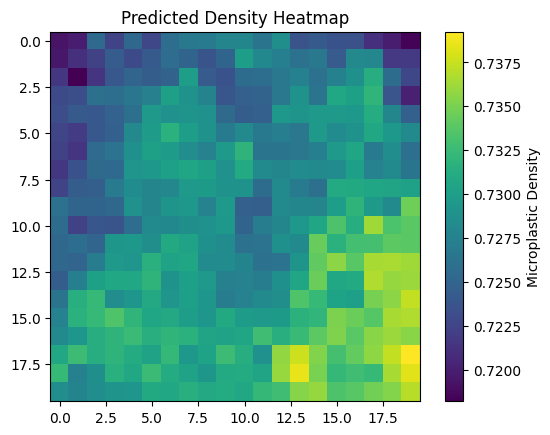

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import swin_t
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from netCDF4 import Dataset as NetCDFDataset
from tqdm import tqdm


# ---------- Model ----------
class SwinRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = swin_t(weights="IMAGENET1K_V1")
        self.backbone.head = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 400)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = self.regressor(features)
        out = out.view(-1, 20, 20)
        return out


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SwinRegressor().to(device)

# ---------- Loss and Optimizer ----------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ---------- Training ----------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, matrices in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, matrices = images.to(device), matrices.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, matrices)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, matrices in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, matrices = images.to(device), matrices.to(device)
            outputs = model(images)
            loss = criterion(outputs, matrices)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


# ---------- Test and Heatmap Visualization ----------
model.eval()
sample_img, _ = test_dataset[0]
sample_img_tensor = sample_img.unsqueeze(0).to(device)
with torch.no_grad():
    pred_matrix = model(sample_img_tensor).cpu().numpy()[0]

plt.imshow(pred_matrix, cmap='viridis')
plt.colorbar(label="Microplastic Density")
plt.title("Predicted Density Heatmap")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import wasserstein_distance

# -------- Evaluation on Test Set --------
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for images, matrices in test_loader:
        images, matrices = images.to(device), matrices.to(device)

        outputs = model(images)  # [B, 20, 20]

        y_true_all.append(matrices.cpu().numpy().reshape(matrices.size(0), -1))
        y_pred_all.append(outputs.cpu().numpy().reshape(outputs.size(0), -1))


y_true_all = np.concatenate(y_true_all, axis=0)  # [N, 400]
y_pred_all = np.concatenate(y_pred_all, axis=0)  # [N, 400]

y_true = y_true_all.flatten()
y_pred = y_pred_all.flatten()

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
corr = np.corrcoef(y_true, y_pred)[0, 1]

emd = wasserstein_distance(y_true, y_pred)

print("Test Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Pearson Corr: {corr:.4f}")
print(f"Wasserstein Distance (EMD): {emd:.4f}")


Test Metrics:
RMSE: 0.0035
MAE: 0.0028
R²: 0.9826
MAPE: 0.72%
Pearson Corr: 0.9447
Wasserstein Distance (EMD): 0.0241


In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository, upload_file
import json

torch.save(model, "swin_regressor.pt")


config = {
    "input_size": 224,
    "output_size": [20, 20],
    "backbone": "swin_tiny_patch4_window7_224",
    "dropout": 0.3
}

with open("config.json", "w") as f:
    json.dump(config, f)



In [ ]:
from huggingface_hub import HfApi

api = HfApi()

repo_url = api.create_repo(
    repo_id="emirkaanozdemr/swin_regressor_microplastic",
    private=False,
    exist_ok=True
)

print(repo_url)


https://huggingface.co/emirkaanozdemr/swin_regressor_microplastic


In [ ]:
from huggingface_hub import Repository

repo = Repository(
    local_dir="./swin_regressor_repo",
    clone_from="emirkaanozdemr/swin_regressor_microplastic"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/emirkaanozdemr/swin_regressor_microplastic into local empty directory.


In [ ]:
from huggingface_hub import HfFolder
HfFolder.save_token("hf_token")


In [ ]:
!git config --global user.name "name"
!git config --global user.email "email"

In [ ]:
import shutil

shutil.copy("swin_regressor.pt", "./swin_regressor_repo/")
shutil.copy("config.json", "./swin_regressor_repo/")

repo.push_to_hub(commit_message="Add full model with class and config")


Upload file swin_regressor.pt:   0%|          | 1.00/108M [00:00<?, ?B/s]

To https://huggingface.co/emirkaanozdemr/swin_regressor_microplastic
   18aa66e..9563227  main -> main

   18aa66e..9563227  main -> main



'https://huggingface.co/emirkaanozdemr/swin_regressor_microplastic/commit/95632270fb52c4f32a6eb787b9dcf6a94a5811a6'